C:\Users\kandi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating Model 1 (1024 max_len):   0%|          | 0/100 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to


📊 Model 1 (1024 max_len)
ROUGE-1:     0.3715
ROUGE-2:     0.1337
ROUGE-L:     0.2188
ROUGE-Lsum:  0.3220
METEOR:      0.2388
BERT Precision: 0.8627
BERT Recall:    0.8423
BERT F1 Score:  0.8521

📊 Model 2 (768 max_len)
ROUGE-1:     0.3681
ROUGE-2:     0.1297
ROUGE-L:     0.2181
ROUGE-Lsum:  0.3171
METEOR:      0.2362
BERT Precision: 0.8623
BERT Recall:    0.8416
BERT F1 Score:  0.8516


C:\Users\kandi\AppData\Local\Temp\ipykernel_20964\1484385217.py:115: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kandi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


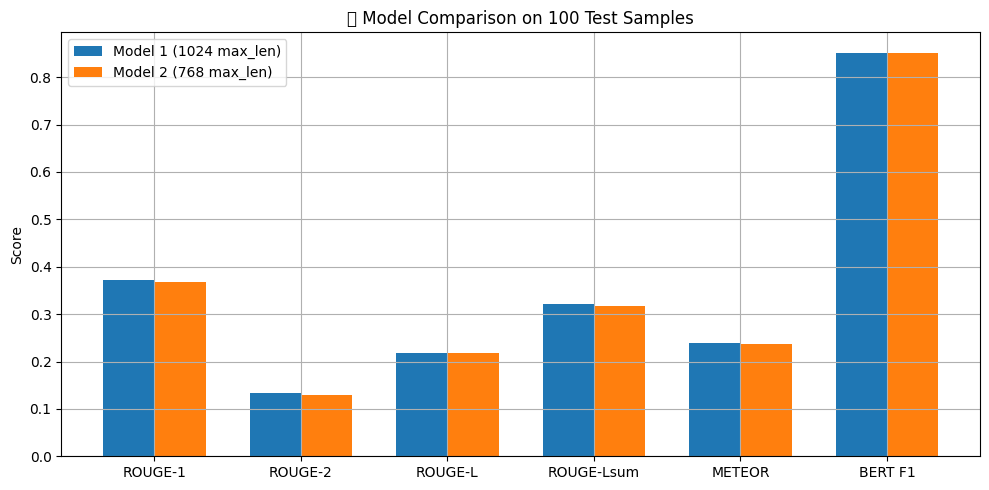

In [1]:
# ✅ STEP 1: Install required libraries
!pip install evaluate bert-score --quiet

# ✅ STEP 2: Import everything
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
from tqdm import tqdm

# ✅ STEP 3: Load test data (100 samples)
dataset = load_dataset("ccdv/arxiv-summarization")
test_data = dataset["test"].select(range(100))

# ✅ STEP 4: Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

# ✅ STEP 5: Define scoring function
def evaluate_model(model_path, label):
    tokenizer = BartTokenizer.from_pretrained(model_path)
    model = BartForConditionalGeneration.from_pretrained(model_path)

    rouge_1s, rouge_2s, rouge_Ls, rouge_Lsums = [], [], [], []
    meteor_scores = []
    bert_precisions, bert_recalls, bert_f1s = [], [], []

    for example in tqdm(test_data, desc=f"Evaluating {label}"):
        article = example["article"]
        reference = example["abstract"]

        inputs = tokenizer(article, return_tensors="pt", truncation=True, max_length=768)
        summary_ids = model.generate(
            **inputs,
            max_length=128,
            num_beams=4,
            no_repeat_ngram_size=3,
            length_penalty=2.0,
            early_stopping=True
        )
        pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        rouge_result = rouge.compute(predictions=[pred], references=[reference])
        rouge_1s.append(rouge_result["rouge1"])
        rouge_2s.append(rouge_result["rouge2"])
        rouge_Ls.append(rouge_result["rougeL"])
        rouge_Lsums.append(rouge_result["rougeLsum"])

        meteor_result = meteor.compute(predictions=[pred], references=[reference])
        meteor_scores.append(meteor_result["meteor"])

        bert_result = bertscore.compute(predictions=[pred], references=[reference], lang="en")
        bert_precisions.append(bert_result["precision"][0])
        bert_recalls.append(bert_result["recall"][0])
        bert_f1s.append(bert_result["f1"][0])

    # Final averages
    result = {
        "label": label,
        "rouge1": sum(rouge_1s) / len(rouge_1s),
        "rouge2": sum(rouge_2s) / len(rouge_2s),
        "rougeL": sum(rouge_Ls) / len(rouge_Ls),
        "rougeLsum": sum(rouge_Lsums) / len(rouge_Lsums),
        "meteor": sum(meteor_scores) / len(meteor_scores),
        "bert_precision": sum(bert_precisions) / len(bert_precisions),
        "bert_recall": sum(bert_recalls) / len(bert_recalls),
        "bert_f1": sum(bert_f1s) / len(bert_f1s)
    }
    return result

# ✅ STEP 6: Evaluate both models
model_1_result = evaluate_model("bart_arxiv_30k_1024_model", "Model 1 (1024 max_len)")
model_2_result = evaluate_model("bart_arxiv_30k_786_model", "Model 2 (768 max_len)")

# ✅ STEP 7: Print comparison
def print_scores(result):
    print(f"\n📊 {result['label']}")
    print(f"ROUGE-1:     {result['rouge1']:.4f}")
    print(f"ROUGE-2:     {result['rouge2']:.4f}")
    print(f"ROUGE-L:     {result['rougeL']:.4f}")
    print(f"ROUGE-Lsum:  {result['rougeLsum']:.4f}")
    print(f"METEOR:      {result['meteor']:.4f}")
    print(f"BERT Precision: {result['bert_precision']:.4f}")
    print(f"BERT Recall:    {result['bert_recall']:.4f}")
    print(f"BERT F1 Score:  {result['bert_f1']:.4f}")

print_scores(model_1_result)
print_scores(model_2_result)

# ✅ STEP 8: Optional bar plot comparison
import numpy as np

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum", "METEOR", "BERT F1"]
values1 = [
    model_1_result["rouge1"], model_1_result["rouge2"], model_1_result["rougeL"],
    model_1_result["rougeLsum"], model_1_result["meteor"], model_1_result["bert_f1"]
]
values2 = [
    model_2_result["rouge1"], model_2_result["rouge2"], model_2_result["rougeL"],
    model_2_result["rougeLsum"], model_2_result["meteor"], model_2_result["bert_f1"]
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, values1, width, label=model_1_result["label"])
plt.bar(x + width/2, values2, width, label=model_2_result["label"])
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("🔍 Model Comparison on 100 Test Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
